In [1]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import librosa.display 
def save_features(fnames, label):
        for filename in fnames:
            sound_file=filename
            y, sr = librosa.load(sound_file, mono=True, duration=30)
            rmse = librosa.feature.rms(y=y)
            y = y[:100000] 

            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {label}'
            file = open('dataset.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())      

In [302]:
df_train

,fname,label
0,./training-a/a0007.wav,0
1,./training-a/a0009.wav,0
2,./training-a/a0011.wav,0
3,./training-a/a0012.wav,0
4,./training-a/a0016.wav,0
...,...,...
29,./training-f/f0090.wav,1
30,./training-f/f0093.wav,1
31,./training-f/f0096.wav,1
32,./training-f/f0099.wav,1


In [300]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

df_train=pd.DataFrame(columns=['fname','label'])
training_folders = ['./training-a/','./training-b/','./training-c/','./training-d/','./training-e/','./training-f/']

for folder in training_folders:
    temp_df = pd.DataFrame()
    temp_df_a = pd.DataFrame()
    file_abnormal = open(folder+'RECORDS-abnormal', 'rt')
    abnormal_records = list(map(lambda x:folder+ x.strip()+".wav", file_abnormal.readlines()))
    abnormal_labels = [1]*len(abnormal_records)
    
    file_normal = open(folder+'RECORDS-normal', 'rt')
    normal_records = list(map(lambda x:folder+ x.strip()+".wav", file_normal.readlines()))
    normal_labels = [0]*len(normal_records)
    temp_df['fname'] = normal_records
    temp_df['label'] = normal_labels
    temp_df_a['fname'] = abnormal_records
    temp_df_a['label'] = abnormal_labels
    df_list = [df_train, temp_df, temp_df_a]  # List of your dataframes
    df_train = pd.concat(df_list)

abnormal_files = df_train[df_train['label'] == 1]['fname']

normal_files = df_train[df_train['label'] == 0]['fname']




In [301]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()



In [5]:

file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
save_features(normal_files.values, 'normal')
save_features(abnormal_files.values, 'abnormal')


In [40]:
data = pd.read_csv('dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
data["label"].replace({"normal": 0, "abnormal": 1}, inplace=True)

y = data.iloc[:,-1]
#encoder = LabelEncoder()
#y = encoder.fit_transform(genre_list)#Scaling the Feature columns
#label_list[label_list['label']=='normal']
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42, shuffle=True)

In [46]:
data.columns[:-1]

Index(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20'],
      dtype='object')

In [34]:
y_train[0]

0

In [35]:
import tensorflow as tf
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], optimizer='adam')

In [37]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               6912      
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 48,129
Trainable params: 48,129
Non-trainable params: 0
_________________________________________________________________


In [43]:
classifier = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=128,validation_data=(x_val, y_val))

Epoch 1/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1280 - accuracy: 0.9662 - precision_5: 0.9126 - recall_5: 0.9292 - val_loss: 0.1833 - val_accuracy: 0.9461 - val_precision_5: 0.8220 - val_recall_5: 0.9327
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9672 - precision_5: 0.9224 - recall_5: 0.9224 - val_loss: 0.1487 - val_accuracy: 0.9461 - val_precision_5: 0.8016 - val_recall_5: 0.9712
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0573 - accuracy: 0.9797 - precision_5: 0.9541 - recall_5: 0.9498 - val_loss: 0.1301 - val_accuracy: 0.9653 - val_precision_5: 0.8839 - val_recall_5: 0.9519
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0517 - accuracy: 0.9841 - precision_5: 0.9655 - recall_5: 0.9589 - val_loss: 0.1325 - val_accuracy: 0.9595 - val_precision_5: 0.8609 - val_recall_5: 0.9519
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.

17/17 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 0.9986 - precision_5: 0.9954 - recall_5: 0.9977 - val_loss: 0.2493 - val_accuracy: 0.9480 - val_precision_5: 0.8532 - val_recall_5: 0.8942
Epoch 72/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 0.9990 - precision_5: 0.9977 - recall_5: 0.9977 - val_loss: 0.2283 - val_accuracy: 0.9461 - val_precision_5: 0.8725 - val_recall_5: 0.8558
Epoch 73/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.9990 - precision_5: 0.9977 - recall_5: 0.9977 - val_loss: 0.2241 - val_accuracy: 0.9499 - val_precision_5: 0.8679 - val_recall_5: 0.8846
Epoch 74/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 0.9986 - precision_5: 0.9977 - recall_5: 0.9954 - val_loss: 0.2255 - val_accuracy: 0.9422 - val_precision_5: 0.8426 - val_recall_5: 0.8750
Epoch 75/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0058 - ac

<AxesSubplot:>

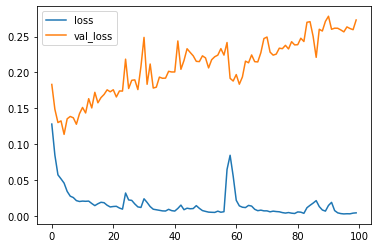

In [44]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [52]:
train_df

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
1598,0.635445,0.033118,123.064762,170.761636,215.826416,0.007362,-527.371948,107.710289,77.608215,42.151966,...,10.712391,4.274422,3.447844,6.353335,8.994369,8.378577,4.480138,-0.144671,-2.531476,0
2181,0.674501,0.065901,164.764928,235.481306,425.280762,0.006818,-419.621735,109.390190,74.525726,33.910313,...,5.762009,0.047637,1.002397,5.842875,9.633109,9.099989,4.737211,-0.046580,-1.785705,0
1156,0.575544,0.070936,224.858668,272.948686,547.338867,0.006789,-403.887787,160.493088,103.029846,37.422222,...,-3.551129,-9.127279,-3.122878,8.249057,15.899296,14.549964,5.890458,-3.525515,-7.498088,0
1106,0.682634,0.069696,195.466179,234.341096,429.949951,0.018781,-399.065369,114.256889,77.484825,35.108120,...,3.131571,-2.415777,0.064623,6.806631,11.754753,11.028378,5.310959,-1.212527,-4.225398,0
619,0.602181,0.095274,116.181192,134.822632,163.861084,0.008368,-435.106415,127.856613,93.711746,53.886299,...,3.916196,-3.072100,-2.456041,2.816631,7.395099,7.404213,2.819007,-3.082762,-6.444741,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538,0.648414,0.065914,181.384813,182.490910,345.739746,0.010316,-460.184814,160.803696,115.293549,60.882225,...,5.146558,-2.079403,-3.178971,0.688278,5.374537,7.125196,5.050777,1.181961,-1.490831,0
1703,0.642520,0.109268,199.551716,240.856469,438.574219,0.012177,-387.200104,159.498627,103.866531,40.673256,...,-2.173039,-7.601149,-1.159954,10.148420,16.905437,14.176900,4.414594,-5.166231,-8.262853,0
656,0.734900,0.105149,139.927682,210.901839,294.213867,0.010421,-408.546478,137.662323,91.910934,39.579151,...,4.306198,-1.197992,2.408378,10.262596,15.269258,13.385219,6.093565,-1.330490,-4.052514,0
1167,0.618614,0.030110,219.096958,251.229777,499.658203,0.013941,-484.763184,161.124802,104.498100,40.449245,...,-0.378589,-7.520133,-3.778586,5.184055,11.064670,9.158198,1.252868,-6.523999,-8.761638,0


In [294]:
csv_data['label'].value_counts().values

array([2575,  665], dtype=int64)

In [297]:
csv_data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.773562,0.046785,71.683518,115.548181,114.916992,0.003206,-511.062744,83.861893,67.891411,49.436592,...,8.716282,5.298057,4.965835,6.514535,7.824809,7.371098,5.167371,2.504720,0.916140,0
1,0.705579,0.008903,196.003855,276.579265,535.748291,0.009190,-623.724915,153.422592,95.196388,30.575415,...,-3.443766,-9.584644,-1.507154,12.163459,20.315411,17.366802,6.421022,-4.051963,-6.906203,0
2,0.701021,0.019787,108.370178,149.160458,167.871094,0.005309,-566.629517,102.712692,77.533882,47.537380,...,4.409506,-0.292595,0.755525,5.369512,9.427371,9.789405,6.233296,1.240494,-1.988515,0
3,0.766901,0.048934,93.327976,152.726981,149.743652,0.004125,-486.193970,83.462822,63.060806,39.504730,...,10.733055,5.349799,4.342487,6.462164,8.765409,8.795993,6.134224,2.377203,-0.213475,0
4,0.763357,0.085216,70.236007,102.443166,113.104248,0.003560,-461.288849,98.746719,79.368568,55.917255,...,9.200042,3.632946,1.813388,3.122399,5.335430,6.267637,5.136646,2.792984,0.866471,0


In [310]:
df_train['fname'].iloc[0]

'./training-a/a0007.wav'

In [283]:
from fastai import *
from fastai.tabular.all import *

csv_data = pd.read_csv('dataset.csv')
csv_data.head()# Dropping unneccesary columns
csv_data = csv_data.drop(['filename'],axis=1)#Encoding the Labels
csv_data["label"].replace({"normal": 0, "abnormal": 1}, inplace=True)

num_cols = csv_data.columns[:-1].to_list()
print(num_cols)
train_df = csv_data.sample(frac = 0.8)
 
test_df = csv_data.drop(train_df.index)

processing_funcs = [Normalize]

# Test Tabular List
nn_df = TabularPandas(train_df, cont_names=num_cols, 
                      procs=processing_funcs, y_names='label', y_block = CategoryBlock())


['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']


In [2]:
train_dl = nn_df.dataloaders()


In [11]:
train_dl.show_batch()


,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.556702,0.024714,295.814202,279.120940,644.403083,0.025124,-454.234070,145.072587,93.281586,34.073345,-8.365990,-21.728835,-10.018123,11.185476,25.181133,23.846470,10.733170,-3.544639,-9.540139,-5.034612,4.631370,11.385749,10.448901,3.220837,-4.541915,-7.363817,0
1,0.812655,0.212198,28.665486,52.068012,47.625736,0.001251,-438.739624,54.181857,51.277504,47.030274,42.113335,37.135647,32.490670,28.317677,24.571249,21.144939,17.978395,15.098324,12.587470,10.515922,8.884375,7.614093,6.585464,5.697229,4.908889,4.242576,0
2,0.792193,0.019059,84.607475,155.516434,124.255367,0.002937,-566.155947,100.801948,74.180641,42.807220,18.748224,8.732720,11.608807,20.209793,26.140896,24.576447,16.374123,6.562526,0.541526,0.631119,5.063288,9.690490,10.957055,8.094890,3.239495,-0.365935,1
3,0.739682,0.059815,158.984588,225.958988,359.692382,0.011774,-425.394684,110.439690,75.311096,35.021000,5.987773,-3.342368,4.427095,18.805513,28.376619,27.307472,17.656696,6.553013,0.701111,2.106549,7.559887,11.646818,10.819645,5.645085,-0.119342,-2.607607,0
4,0.765972,0.037826,88.521415,194.680832,135.791016,0.000767,-541.488037,132.470460,87.382774,36.085724,-0.581899,-12.150122,-1.939614,16.809673,29.585743,28.999233,17.714069,4.709465,-1.639539,1.152687,9.013599,15.082356,14.833284,8.817811,1.496133,-2.421109,0
5,0.824146,0.319241,18.427039,60.167292,24.554438,0.000685,-421.103210,41.107025,36.674655,31.275042,26.494919,23.143934,21.270521,20.394501,19.780447,18.821083,17.362102,15.691808,14.237334,13.249958,12.664223,12.164690,11.417712,10.318063,9.058782,7.986651,0
6,0.766901,0.048934,93.327972,152.726974,149.743650,0.004125,-486.193970,83.462821,63.060807,39.504730,21.834000,14.647041,16.821287,23.045071,27.129425,25.488613,18.774685,10.733055,5.349799,4.342487,6.462164,8.765409,8.795993,6.134224,2.377203,-0.213475,0
7,0.569099,0.066388,282.455926,218.239288,514.874265,0.020269,-443.665191,174.356307,115.780343,48.185509,-2.090154,-20.793119,-11.023209,10.839413,26.449871,26.000812,11.944910,-5.025155,-14.423481,-12.655131,-3.934491,4.003831,5.825396,1.835737,-3.315045,-4.814230,1
8,0.819915,0.175289,22.792749,54.218967,33.288571,0.001101,-478.011810,50.005333,46.288593,40.992367,35.149620,29.711579,25.299088,22.101324,19.932497,18.395761,17.074652,15.680455,14.116204,12.456199,10.869145,9.525817,8.528096,7.880048,7.501327,7.267360,0
9,0.688505,0.071160,220.869887,247.383837,496.801756,0.014718,-415.133240,121.471870,81.087494,34.340473,0.151421,-11.341097,-2.700494,14.238485,26.372553,26.771868,17.332588,5.747701,-0.528481,0.908312,6.734517,11.173821,10.437345,5.134436,-0.735139,-3.075647,0


2575

In [261]:
n = csv_data['label'].value_counts()[0]
a = csv_data['label'].value_counts()[1]
w_a = (a + n) / ( a)
w_n = (a + n) / ( n)

class_weights=torch.FloatTensor([w_n,w_a])
loss_func_new = CrossEntropyLossFlat(weight=class_weights)


In [262]:
dls = TabularDataLoaders.from_df(train_df, path='.', y_names="label",  
                                 cont_names = num_cols, 
                                 procs=processing_funcs, 
                                 y_block = CategoryBlock())


In [270]:
tab_learn = tabular_learner(dls, layers=[64,64,32,32,16], metrics=[accuracy, error_rate, Recall(), Precision(),F1Score()],loss_func=loss_func_new )

In [322]:
import sklearn

SuggestedLRs(valley=0.00363078061491251)

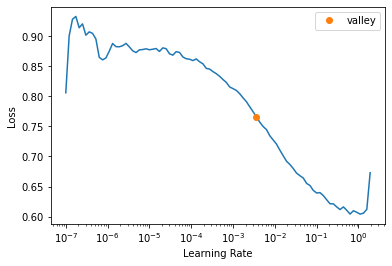

In [272]:
tab_learn.lr_find()


In [273]:
tab_learn.fit_one_cycle(40, lr_max=slice(9e-4,3e-3))


epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,f1_score,time
0,0.730383,0.605448,0.727799,0.272201,0.680851,0.365714,0.475836,00:00
1,0.607374,0.448955,0.805019,0.194981,0.872340,0.479532,0.618868,00:00
2,0.513022,0.383151,0.803089,0.196911,0.946809,0.478495,0.635714,00:00
3,0.433928,0.343403,0.849421,0.150579,0.904255,0.551948,0.685484,00:00
4,0.375787,0.303480,0.872587,0.127413,0.893617,0.600000,0.717949,00:00
5,0.333190,0.305336,0.893822,0.106178,0.882979,0.653543,0.751131,00:00
6,0.313832,0.327214,0.849421,0.150579,0.861702,0.554795,0.675000,00:00
7,0.303177,0.308820,0.870656,0.129344,0.872340,0.598540,0.709957,00:00
8,0.287491,0.312826,0.876448,0.123552,0.851064,0.615385,0.714286,00:00
9,0.279936,0.308253,0.862934,0.137066,0.851064,0.583942,0.692641,00:00


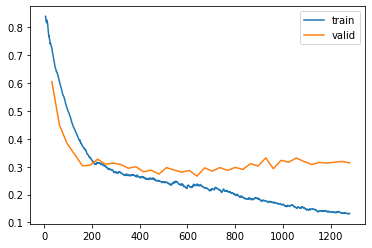

In [274]:
tab_learn.recorder.plot_loss()


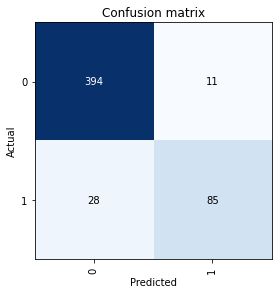

In [252]:
interpret_spec=ClassificationInterpretation.from_learner(tab_learn)
interpret_spec.plot_confusion_matrix()